- Student name: Duy Hieu Nguyen
- SID: 33694052

# 1. **Model Complexity and Model Selection**

## Question 1 KNN Regressor
### Task 1: Implement a KNN regressor using the scikit-learn conventations

Importing necessary libraries


In [4]:
# Importing necessary libraries
from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt

KnnRegressor Class

In [5]:
class KnnRegressor(BaseEstimator):
    def __init__(self, k=5):
        self.k = k
        self.x_train_kdtree_ = None
        self.y_train = None
    
    def fit(self, x, y):
        self.x_train_kdtree_ = KDTree(x)
        self.y_train_ = y
        return self
    
    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)

        neighbours_labels = self.y_train_[neighbours]
        m = np.mean(neighbours_labels, axis=1)
        return m.squeeze()

### Task 2: Testing
 To test your implementation, load the datasets diabetes and california housing through the functions load diabetes and fetch california housing, both of which are available in the module sklearn.datasets. For both datasets, perform a training/test split (using a fraction of 0.6 of the data as training data), fit your KNN regressor to the training portion (using some guess for a good value of k), and report the training and test errors.

In [16]:
from sklearn.metrics import mean_squared_error
def TestingKnnRegressor(datasets, k=3):
    # Load the dataset
    data = datasets()

    # Split the dataset
    x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.6, random_state=1)

    # Instantiate the regressor and fit the training data
    knn = KnnRegressor(k)
    knn.fit(x_train, y_train)

    # Predict on the training and test datasets
    y_hat_train = knn.predict(x_train)
    y_hat_test = knn.predict(x_test)

    # Calculate the Mean Squared Errors
    # train_error = mean_squared_error(y_train, y_hat_train)    
    train_error = np.mean((y_train - y_hat_train) ** 2)
    test_error = np.mean((y_test - y_hat_test) ** 2)
    # print(f"Training Error: {train_error}")
    # print(f"Test Error: {test_error}")
    return train_error, test_error


Plotting error

In [11]:
def plot_errors_for_datasets(data, data_name, max_k=50):
    train_errors = []
    test_errors = []
    for k in range(1, max_k+1):
        tr_error, test_error = TestingKnnRegressor(data, k)
        train_errors.append(tr_error)
        test_errors.append(test_error)
        
    # Plotting the errors
    ks = np.arange(1, max_k+1)
    plt.figure(figsize=(5, 5))
    plt.plot(ks, train_errors, label='Train Error', marker='o')
    plt.plot(ks, test_errors, label='Test Error', marker='o')
    plt.xlabel('1/k (Number of Neighbors)')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Effect of k on Train and Test Errors for {data_name} Dataset')
    plt.legend()
    # plt.xscale('log')
    plt.grid(True)
    plt.show()
    
#     return train_errors, test_errors

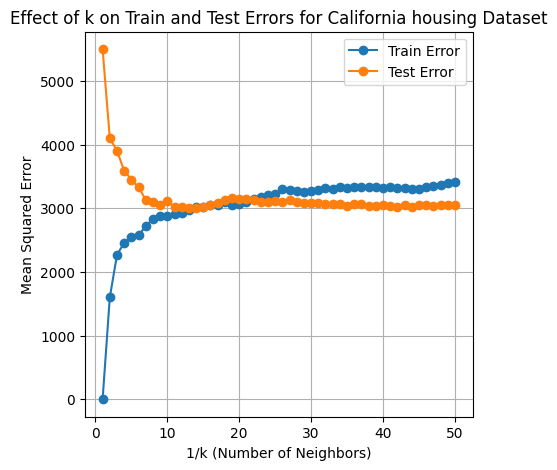

For diabetes datasets, with k = 3:
train error:  2267.57
test error:  3901.8


In [17]:
plot_errors_for_datasets(load_diabetes, "California housing")
train, test = TestingKnnRegressor(load_diabetes, k = 3)
print("For diabetes datasets, with k = 3:")
print("train error: ", round(train, 2))
print("test error: ", round(test, 2))

## For Diabetes dataset:
- Test error falls quickly then fluctuate around 3000.
- From $K=15$ train error is higher than test error.
- When $K=3$:
    - train error:  $2267.57$
    - test error:  $3901.80$

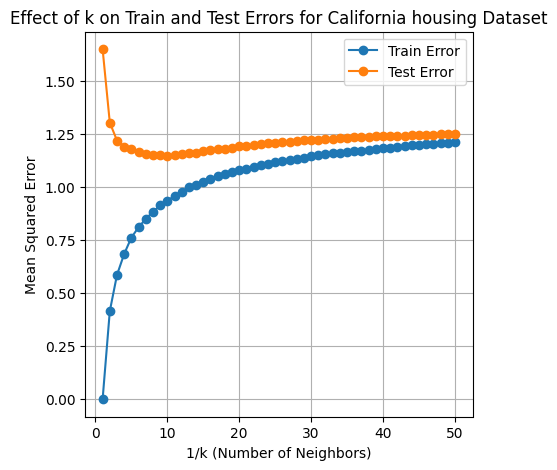

For california housing datasets, with k = 3:
train error:  0.59
test error:  1.22


In [ ]:
plot_errors_for_datasets(fetch_california_housing, "California housing")
train, test = TestingKnnRegressor(fetch_california_housing, k = 3)
print("For california housing datasets, with k = 3:")
print("train error: ", round(train, 2))
print("test error: ", round(test, 2))

## For California housing dataset:
- Both test and train error have a smooth U shape. Test error drops significantly when $K=10$ then increase to $1.25$. While Train error rises gradually from $K=10$
- When $K=3$:
    - train error:  0.59
    - test error:  1.22

## Question 2: L-fold Cross Validation

### Task 1: L-Fold class

In [ ]:
class LFold:
    def __init__(self, L, random_seed=1):
        # Number of splits
        self.L = L
        # Random seed for reuse specific random state
        self.random_seed = random_seed

    def get_n_splits(self, x=None, y=None, groups=None):
        # Return the number of splitting iterations
        return self.L

    def split(self, x, y=None, groups=None):
        # Generate a random permutation of the indices
        np.random.seed(self.random_seed)
        shuffled_indices = np.random.permutation(len(x))

        # Calculate the size of each fold
        fold_size = len(x) // self.L
        for i in range(self.L):
            # Define the start and end indices for the test set
            start = i * fold_size
            end = (i + 1) * fold_size
            
            # Test indices for the current fold
            test_idx = shuffled_indices[start:end]
            
            # Train indices are all indices that are not in the test set
            train_idx = np.concatenate([shuffled_indices[:start], shuffled_indices[end:]])
            
            yield train_idx, test_idx

In [ ]:
# Testing LFold with list[1 -> 20]
for idx_train, idx_test in LFold(5).split(list(range(20))):
    print(idx_train, idx_test)

[ 2 14  4 17  7  1 13  0 19 18  9 15  8 12 11  5] [ 3 16  6 10]
[ 3 16  6 10  7  1 13  0 19 18  9 15  8 12 11  5] [ 2 14  4 17]
[ 3 16  6 10  2 14  4 17 19 18  9 15  8 12 11  5] [ 7  1 13  0]
[ 3 16  6 10  2 14  4 17  7  1 13  0  8 12 11  5] [19 18  9 15]
[ 3 16  6 10  2 14  4 17  7  1 13  0 19 18  9 15] [ 8 12 11  5]


### Task 2: Standard deviation and best K

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

def evaluation(max_k, cv, data, target):
    r = cv.get_n_splits()
    test_results = np.zeros(shape=(r, max_k))
    train_results = np.zeros(shape=(r, max_k))
    for k in range(1, max_k+1):
        knn = KnnRegressor(k)
        cv_res = cross_validate(knn, data, target, cv=cv, return_train_score=True, scoring=make_scorer(mean_squared_error, greater_is_better=False))
        test_results[:, k-1] = -cv_res['test_score']  # Negate the values because error should be lower ('greater_is_better=False')
        train_results[:, k-1] = -cv_res['train_score']
    # train and test results are (L x max_K) matrix
    return train_results.mean(axis=0), train_results.std(axis=0), test_results.mean(axis=0), test_results.std(axis=0)

This function plots the standard deviations (std) for both training and testing errors.

In [ ]:
def plot_std_results(train_std, test_std, dataset_name):
    ks = np.arange(1, train_std.shape[0] + 1)
    
    # Calculate standard deviations for train and test results
    plt.figure(figsize=(8, 4))
    plt.plot(ks, train_std, marker='o', label='Train Std')
    plt.plot(ks, test_std, marker='o', label='Test Std')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Standard Deviation of MSE')
    plt.title(f'Standard Deviation of Mean Squared Error for {dataset_name} Dataset')
    plt.legend()
    plt.grid(True)
    plt.show()


### For Diabetes dataset:
- $k=20$ performs best in terms of the test error, which matter to estimate the performance on unseen data.
- The min test error in this case is $3170.94$
- Standard deviation of MSE has U-shape curve. It drops quickly then gradually increase.
- Overfitting when $k$ smaller than 20 and underfitting when $k$ larger than 20.

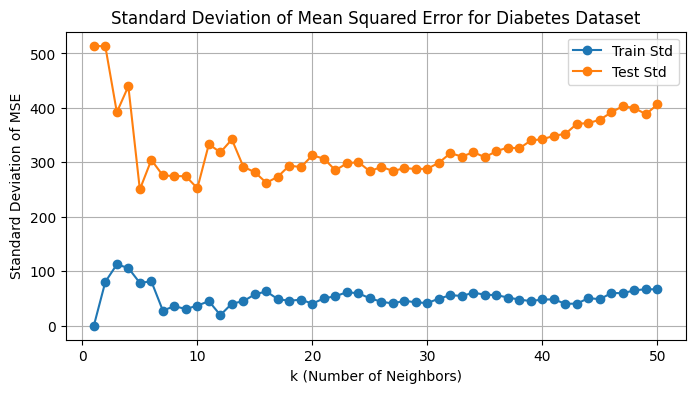

Best k that minimize the test error is: 20 (test error: 3170.94)


In [ ]:
dataset = load_diabetes()
train_mean, train_std, test_mean, test_std = evaluation(max_k=50, cv=LFold(5), data=dataset.data, target=dataset.target)
plot_std_results(train_std, test_std, "Diabetes")
best_k = np.argmin(test_mean) + 1
print(f"Best k that minimize the test error is: {best_k} (test error: {round(test_mean[best_k-1], 2)})")

### For California dataset:
- $k=9$ performs best in terms of the test error, which matter to estimate the performance on unseen data.
- The min test error in this case is $1.11$
- Standard deviation of MSE drops quickly then fluctuate between 0.01 and 0.015.
- Overfitting when $k$ smaller than 9 and underfitting when $k$ larger than 9.

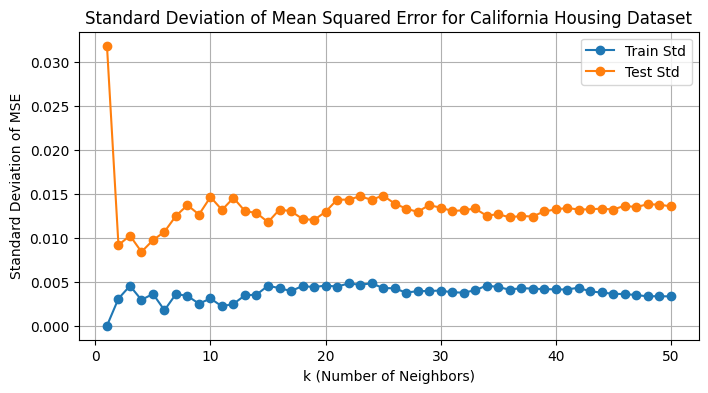

Best k that minimize the test error is: 9 (test error: 1.11)


In [ ]:
dataset = fetch_california_housing()
train_mean, train_std, test_mean, test_std = evaluation(max_k=50, cv=LFold(5), data=dataset.data, target=dataset.target)
plot_std_results(train_std, test_std, "California Housing")
best_k = np.argmin(test_mean) + 1
print(f"Best k that minimize the test error is: {best_k} (test error: {round(test_mean[best_k-1], 2)})")

### Task 3: Effect of K and L

This function plots the mean training and test errors against the choice of K with error bars (using the standard error of the mean)

In [ ]:
def plot_evaluation_results(train_mean, train_std, test_mean, test_std, dataset_name):
    ks = np.arange(1, train_mean.shape[0] + 1)
    
    # Calculate z for error bars (assuming L=5 for now)
    z = (5**0.5)/1.96
    plt.figure(figsize=(8, 4))
    
    # Plotting results for train and test sets
    plt.errorbar(ks, train_mean, yerr=train_std/z, marker='o', label='train')
    plt.errorbar(ks, test_mean, yerr=test_std/z, marker='o', label='test')
    plt.xlabel('$k$')
    plt.ylabel('Mean Squared Error')
    plt.title(f'{dataset_name} Dataset: Effect of k')
    best_k = np.argmin(test_mean) + 1
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best K: {best_k}, test error: {round(test_mean[best_k-1], 2)}')
    plt.legend()
    plt.grid(True)
    plt.show()

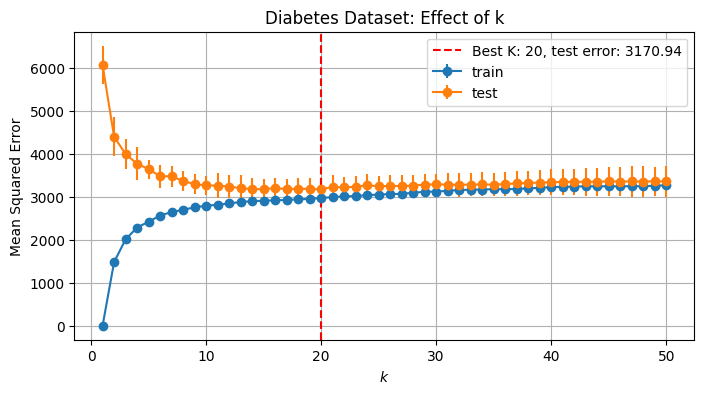

In [ ]:
# Testing the function with the Diabetes dataset results
dataset = load_diabetes()
train_mean, train_std, test_mean, test_std = evaluation(max_k=50, cv=LFold(5), data=dataset.data, target=dataset.target)
plot_evaluation_results(train_mean, train_std, test_mean, test_std, "Diabetes")

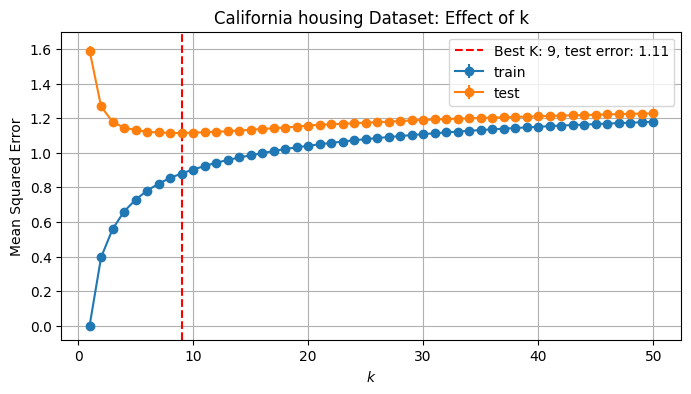

In [ ]:
# Testing the function with the California housing dataset results
dataset = fetch_california_housing()
train_mean, train_std, test_mean, test_std = evaluation(max_k=50, cv=LFold(5), data=dataset.data, target=dataset.target)
plot_evaluation_results(train_mean, train_std, test_mean, test_std, "California housing")

### Analyze
**Effect of L:**
- With a higher $L$, each $K$ is evaluated on more folds, meaning that the average $MSE$ is computed over larger values. Averaging over more values can smooth out the noise and fluctuations, leading to a more stable curve. 
- Moreover, each training set in the cross-validation becomes more representative of the entire dataset (because size of test data is smaller), leading to a more unbiased estimation.
- However, high $L$ results in computationally expensive, since the model needs to be trained over more dataset.

**Effect of K:**
- With low $K$: The model is flexible and can be very sensitive to noise in the training data, which refers to overfitting.
- With high $K$: The predictions are based on a larger number of data points, which can reduce variance. The model less complex then it might be underfitting
- For Diabetes dataset, overfitting when $K < K\_best = 20$ and underffiting when $K > K\_best = 20$
- For California housing dataset, overfitting when $K < K\_best = 9$ and underffiting when $K > K\_best = 9$

## Question 3: Nested CV


### Task 1. KnnRegressorCV class:

In [ ]:
class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
        self.ks = ks
        self.cv = cv
        self.k_ = None  # Placeholder for the optimal k

    def fit(self, x, y):
        # Initialize best score to a high value (since we're looking at error, lower is better)
        best_score = np.inf
        
        # For each k value, perform cross-validation and determine which k gives the lowest error
        for k in self.ks:
            knn = KnnRegressor(k)
            cv_scores = cross_validate(knn, x, y, cv=self.cv, scoring=make_scorer(mean_squared_error, greater_is_better=False))
            mean_cv_score = -cv_scores['test_score'].mean()  # Negate the score because greater_is_better=False returns negative values
            if mean_cv_score < best_score:
                best_score = mean_cv_score
                self.k_ = k
                
        # After determining the best k, train the model with the entire training data using the optimal k
        self.model = KnnRegressor(self.k_)
        self.model.fit(x, y)
        
        return self

    def predict(self, x):
        return self.model.predict(x)


### Task 2. Perform Outer Train-Test Split and Evaluate KnnRegressorCV

#### Nested cross-validation 
- Outer cross-validation using `Lfold()` to further split the datasets into multiple training and test sets
- The KnnRegressorCV is used to fit the training data. It internally determines the best value for k by performing its own internal cross-validation

In [ ]:
datasets = {
    "Diabetes": load_diabetes(),
    "California Housing": fetch_california_housing()
}
outer_cv = LFold(5)

for name, dataset in datasets.items():
    selected_ks = []
    mses = []
    for train_idx, test_idx in outer_cv.split(dataset.data):
        x_train, x_test = dataset.data[train_idx], dataset.data[test_idx]
        y_train, y_test = dataset.target[train_idx], dataset.target[test_idx]
        

        # Fit and predict using KnnRegressorCV
        knn_cv = KnnRegressorCV()
        knn_cv.fit(x_train, y_train)
        
        y_pred = knn_cv.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)   
        selected_ks.append(knn_cv.k_)
        mses.append(mean_squared_error(y_test, y_pred))
                    
    print(f"Dataset: {name}")
    print(f"Selected k values across the folds: {selected_ks}")
    print(f"Mean selected k: {np.mean(selected_ks)}")
    print(f"Best k in terms of lowest MSE: {selected_ks[np.argmin(mses)]}, MSE = {round(np.min(mses), 2)}")
    print("-------------------------------------------------")

Dataset: Diabetes
Selected k values across the folds: [15, 16, 20, 16, 13]
Mean selected k: 16.0
Best k in terms of lowest MSE: 16, MSE = 2939.65
-------------------------------------------------
Dataset: California Housing
Selected k values across the folds: [8, 8, 8, 8, 8]
Mean selected k: 8.0
Best k in terms of lowest MSE: 8, MSE = 1.1
-------------------------------------------------


#### Results:
**Diabetes Dataset**:
  - The optimal number of neighbors $K$ varied across the different folds: 17, 14, 12, 18, 15, 13
  - On average, mean $K$ = 14.83.
  - The lowest mean squared error = 2721.4, when $K=15$.

**California Housing Dataset**:
  - The optimal number of neighbors $K$ varied across the different folds: 9, 7, 10, 8, 8, 9.
  - On average, mean $K$ = 8.5.
  - The lowest mean squared error = 1.07, when $K=8$.

**Factor determine selecting best mode**:
  - **Size of the Dataset**: Larger datasets generally provide more reliable estimates of model performance during cross-validation.
  - **Choice of L in L-Fold CV**: Evaluated on more folds, meaning that the average $K$ is computed over larger values. 
  - **Range of K in internal CV**: If the optimal $K$ is outside the considered range $[1, 20]$, the internal CV might not select the best model.